In [1]:
pip install nltk


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import nltk
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package omw-1.4 to /home/u215422/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/u215422/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/u215422/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/u215422/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer


from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier



import warnings
warnings.filterwarnings ('ignore')

2024-03-09 00:38:08.184219: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
df = pd.read_csv("text.csv")
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [6]:
df = df.drop(columns=['Unnamed: 0'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [7]:
df.duplicated().sum()
df = df.drop_duplicates()

In [8]:
df1 = df.copy()

In [9]:
unique_review = df1['text'].unique()
unique_review

array(['i just feel really helpless and heavy hearted',
       'ive enjoyed being able to slouch about relax and unwind and frankly needed it after those last few weeks around the end of uni and the expo i have lately started to find myself feeling a bit listless which is never really a good thing',
       'i gave up my internship with the dmrg and am feeling distraught',
       ...,
       'i feel very curious be why previous early dawn in the time here don t you seek his trouble',
       'i feel that becuase of the tyranical nature of the government in el salvador and the savage social conditions of the general people that the set of thought to run the shoe shop in miguel marmols testimoney was able to work',
       'i think that after i had spent some time investigating the surroundings and things i started to feel more curious about other people'],
      dtype=object)

In [10]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\.\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\w*\d\w*', '', text)
    tokens = word_tokenize(text)
    # Remove stopwords and stem tokens
    cleaned_tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]
    # Join the tokens back into a single string
    cleaned_text = ' '.join(cleaned_tokens)
    return cleaned_text

# Clean the text data in the 'text' column of DataFrame df
df1['cleaned_text'] = df1['text'].apply(clean_text)

# Print the DataFrame with cleaned text data
print(df1[['text', 'cleaned_text']])

                                                     text  \
0           i just feel really helpless and heavy hearted   
1       ive enjoyed being able to slouch about relax a...   
2       i gave up my internship with the dmrg and am f...   
3                              i dont know i feel so lost   
4       i am a kindergarten teacher and i am thoroughl...   
...                                                   ...   
416804  i feel like telling these horny devils to find...   
416805  i began to realize that when i was feeling agi...   
416806  i feel very curious be why previous early dawn...   
416807  i feel that becuase of the tyranical nature of...   
416808  i think that after i had spent some time inves...   

                                             cleaned_text  
0                        feel realli helpless heavi heart  
1       ive enjoy abl slouch relax unwind frankli need...  
2                    gave internship dmrg feel distraught  
3                          

In [11]:
df1['cleaned_text'] = df1['cleaned_text'].str.replace("http", "").str.replace("href", "").str.replace("img", "").str.replace("irc", "")

In [12]:
unique_review = df1['cleaned_text'].unique()
unique_review

array(['feel realli helpless heavi heart',
       'ive enjoy abl slouch relax unwind frankli need last week around end uni expo late start find feel bit listless never realli good thing',
       'gave internship dmrg feel distraught', ...,
       'feel curiou previou earli dawn time seek troubl',
       'feel becuas tyran natur govern el salvador savag social condit gener peopl set thought run shoe shop miguel marmol testimoney abl work',
       'think spent time investig surround thing start feel curiou peopl'],
      dtype=object)

In [13]:
df1.label.value_counts()

label
1    140779
0    120989
3     57235
4     47664
2     34497
5     14959
Name: count, dtype: int64

In [14]:
mapping = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

df1['Emotion'] = df1['label'].map(mapping)

In [15]:
df2 = df1.copy()
X_train, X_test, y_train, y_test = train_test_split(df2['cleaned_text'], df2['label'], test_size=0.2, random_state=42)

In [16]:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)

In [17]:
X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100, padding='post')
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100, padding='post')

In [18]:
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=50000, output_dim=16, input_length=100))
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(units=64, activation='relu'))
cnn_model.add(Dense(units=6, activation='softmax'))

2024-03-09 00:40:01.946620: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [19]:
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           800000    
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           10368     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 819014 (3.12 MB)
Trainable params: 819014 (3.12 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_cnn = cnn_model.fit(X_train_padded, y_train, epochs=50, 
                             validation_data=(X_test_padded, y_test),
                             callbacks=[early_stopping])

Epoch 1/50
10404/10404 [==============================] - 383s 37ms/step - loss: 0.2301 - accuracy: 0.8973 - val_loss: 0.1799 - val_accuracy: 0.9129
Epoch 2/50
10404/10404 [==============================] - 382s 37ms/step - loss: 0.1507 - accuracy: 0.9216 - val_loss: 0.1544 - val_accuracy: 0.9182
Epoch 3/50
10404/10404 [==============================] - 394s 38ms/step - loss: 0.1346 - accuracy: 0.9268 - val_loss: 0.1564 - val_accuracy: 0.9165
Epoch 4/50
10404/10404 [==============================] - 386s 37ms/step - loss: 0.1229 - accuracy: 0.9307 - val_loss: 0.1575 - val_accuracy: 0.9141
Epoch 5/50
10404/10404 [==============================] - 390s 38ms/step - loss: 0.1153 - accuracy: 0.9338 - val_loss: 0.1679 - val_accuracy: 0.9167


2601/2601 [==============================] - 7s 3ms/step


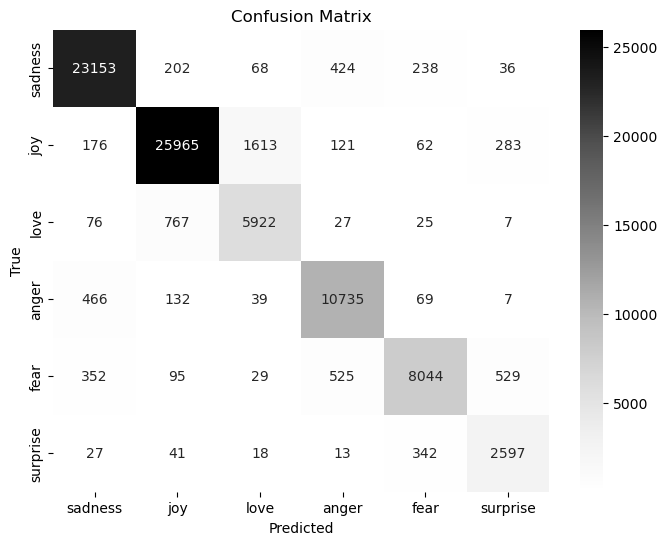

In [21]:
y_pred = np.argmax(cnn_model.predict(X_test_padded), axis=1)

conf_mat = confusion_matrix(y_test, y_pred)

emotion_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greys', 
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [22]:
target_names = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']  
report = classification_report(y_test, y_pred, target_names=target_names)

print(report)

              precision    recall  f1-score   support

     Sadness       0.95      0.96      0.96     24121
         Joy       0.95      0.92      0.94     28220
        Love       0.77      0.87      0.82      6824
       Anger       0.91      0.94      0.92     11448
        Fear       0.92      0.84      0.88      9574
    Surprise       0.75      0.85      0.80      3038

    accuracy                           0.92     83225
   macro avg       0.88      0.90      0.88     83225
weighted avg       0.92      0.92      0.92     83225



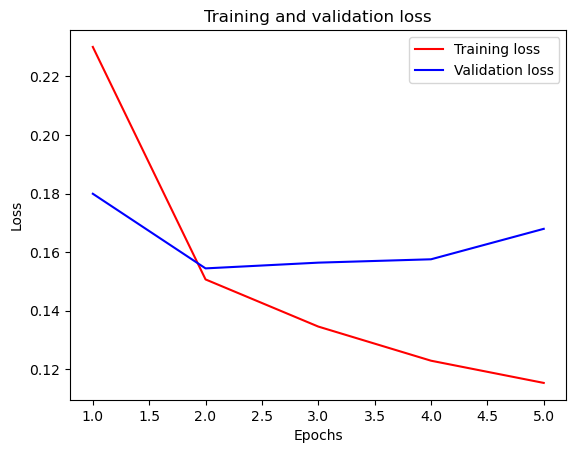

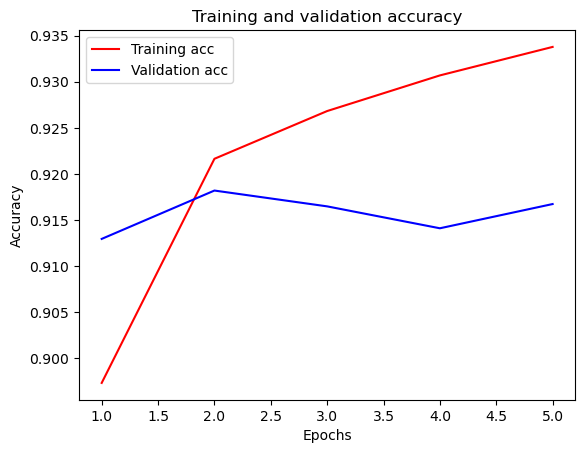

In [23]:
train_loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
train_acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
import re
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def clean_text(text):
    # Your cleaning logic goes here
    # For example, you can lowercase the text, remove special characters, etc.
    cleaned_text = text.lower()
    cleaned_text = re.sub(r'http\S+', '', cleaned_text)
    cleaned_text = re.sub(r'www\.\S+', '', cleaned_text)
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)
    cleaned_text = re.sub('\w*\d\w*', '', cleaned_text)
    return cleaned_text

def preprocess_text(text):
    # Clean the text
    cleaned_text = clean_text(text)
    print("Cleaned Text:", cleaned_text)  # Debug print
    # Tokenize and pad the text
    tokenized_text = pad_sequences(tokenizer.texts_to_sequences([cleaned_text]), maxlen=100, padding='post')
    print("Tokenized Text:", tokenized_text)  # Debug print
    return tokenized_text

def classify_emotion(text):
    # Preprocess the input text
    preprocessed_text = preprocess_text(text)
    print("Preprocessed Text:", preprocessed_text)  # Debug print
    # Predict the emotion label
    predicted_label = np.argmax(cnn_model.predict(preprocessed_text), axis=1)[0]
    print("Predicted Label:", predicted_label)  # Debug print
    # Map the predicted label to the corresponding emotion category
    emotion_mapping = {0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger', 4: 'Fear', 5: 'Surprise'}
    predicted_emotion = emotion_mapping[predicted_label]
    return predicted_emotion

# Continuous input loop
while True:
    # Get user input
    input_text = input("Enter your text (or type 'exit' to quit): ")
    print("Input Text:", input_text)  # Debug print
    # Check if user wants to exit
    if input_text.lower() == 'exit':
        print("Exiting...")
        break
    # Predict emotion for input text
    predicted_emotion = classify_emotion(input_text)
    print("Predicted Emotion:", predicted_emotion)


Enter your text (or type 'exit' to quit):  I am satisfied with the support


Input Text: I am satisfied with the support
Cleaned Text: i am satisfied with the support
Tokenized Text: [[18906 13464 33673    92     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Preprocessed Text: [[18906 13464 33673    92     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0  

Enter your text (or type 'exit' to quit):  exit


Input Text: exit
Exiting...
